# 🧠 Subject-Conditioned Meta-Learning for ErrP-Driven BCIs

**NEW APPROACH: Explicit Subject-Specific Conditioning**

---

## 🎯 Motivation

**Previous Attempts:**
1. ❌ **MAML-PPO (Policy-only)**: Failed - couldn't handle inter-subject variability
2. ⚠️ **MAML-Encoder / ANIL (Representation-level)**: Improved but still underperformed pooled baselines

**Diagnosed Bottleneck:**
- Subject-specific signal geometry is NOT explicitly modeled
- Current methods assume a single universal representation works for all subjects
- Inter-subject differences in EEG topography and amplitude are averaged out

**Solution: Subject-Conditioned Meta-Learning**

```
Support Set (K trials)
    ↓
SubjectEncoder (learns z_s from support set)
    ↓
Subject Embedding z_s (8-16 dims)
    ↓
┌────────────────────────────────────────┐
│ ConditionedEEGEncoder                  │
│   (FiLM: γ, β from z_s)               │
│   Applies: h' = γ(z_s) ⊙ h + β(z_s) │
└────────────────────────────────────────┘
    ↓
TaskHead (classifier)
```

**Why This Should Work:**
- ✅ Explicitly infers subject-specific latent factors from support set
- ✅ Conditions encoder activations via FiLM (Feature-wise Linear Modulation)
- ✅ Learned conditioning (not hand-crafted subject IDs)
- ✅ Meta-learning optimizes for rapid subject adaptation
- ✅ Addresses inter-subject variability at the architectural level

**Expected Outcomes:**
- 📈 Improved low-K (5, 10) performance
- 📉 Reduced inter-subject variance
- 🎯 Competitive with or superior to pooled baselines

---

## 📋 Notebook Structure

1. **Setup & Configuration** (REUSED)
2. **Dataset Loading & Preprocessing** (REUSED)
3. **Feature Extraction & PCA** (REUSED)
4. **LOSO Split Construction** (REUSED)
5. **Subject-Conditioned Architecture** (NEW)
6. **Meta-Training Loop** (NEW)
7. **Baselines** (REUSED)
8. **Evaluation & Visualization** (REUSED)
9. **Experimental Execution** (NEW)

---

---
## 🔹 Section 1: Setup & Configuration

**REUSED** from existing pipeline with minor modifications.

In [1]:
# REUSED: Core imports

# Core scientific computing
import numpy as np
import pandas as pd
import scipy
from scipy import signal
from scipy.stats import zscore

# Machine learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut

# EEG signal processing
import mne
from mne import create_info, EpochsArray
from mne.io import RawArray

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import os
import re
import glob
import warnings
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Tuple, Optional
import json
from tqdm.auto import tqdm

# Configuration
warnings.filterwarnings('ignore')
mne.set_log_level('WARNING')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"MNE version: {mne.__version__}")
print(f"NumPy version: {np.__version__}")

✓ All imports successful
PyTorch version: 2.8.0+cu126
MNE version: 1.11.0
NumPy version: 2.0.2


In [2]:
# REUSED: Global configuration

class Config:
    """
    Global configuration for reproducible experiments.
    
    MODIFIED: Updated for subject-conditioned meta-learning.
    """
    
    # ─── Dataset Paths (READ-ONLY) ───
    DATASET_ROOT = "/kaggle/input/inria-bci-challenge/inria-bci-challenge"
    TRAIN_DIR = os.path.join(DATASET_ROOT, "train")
    TEST_DIR = os.path.join(DATASET_ROOT, "test")
    LABELS_FILE = os.path.join(DATASET_ROOT, "TrainLabels.csv")
    CHANNELS_FILE = os.path.join(DATASET_ROOT, "ChannelsLocation.csv")

    # ─── Output Paths (WRITABLE) ───
    OUTPUT_ROOT = "/kaggle/working/results_subject_conditioned"
    RESULTS_DIR = OUTPUT_ROOT
    FIGURES_DIR = os.path.join(OUTPUT_ROOT, "figures")
    METRICS_DIR = os.path.join(OUTPUT_ROOT, "metrics")
    CHECKPOINT_DIR = os.path.join(OUTPUT_ROOT, "checkpoints")
    
    # ─── EEG Parameters ───
    TMIN = -0.2  # Baseline start (200 ms before feedback)
    TMAX = 0.6   # Epoch end (600 ms after feedback)
    BASELINE = (-0.2, 0.0)  # Baseline correction window
    
    # Preprocessing
    LOWCUT = 1.0   # High-pass filter (Hz)
    HIGHCUT = 30.0  # Low-pass filter (Hz)
    NOTCH_FREQ = 50.0  # Powerline noise (Hz)
    
    # Feature extraction
    FREQ_BANDS = {
        'theta': (4, 7),
        'alpha': (8, 12),
        'beta': (13, 30)
    }
    
    PCA_VARIANCE = 0.95  # Retain 95% variance
    
    # ─── Meta-Learning Parameters ───
    K_SHOTS = [5, 10, 20, 50]  # Few-shot adaptation steps
    N_SEEDS = 3  # Random seeds for repeated experiments
    
    # ─── Subject-Conditioned Meta-Learning (NEW) ───
    SUBJECT_EMBED_DIM = 32  # Dimension of subject embedding z_s (increased for more capacity)
    ENCODER_HIDDEN = 64     # Hidden dimension of EEG encoder
    ENCODER_OUTPUT = 32     # Output dimension of EEG encoder
    
    # ─── Reproducibility ───
    RANDOM_SEEDS = [42, 123, 456]
    
    # ─── Device Selection ───
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create output directories
os.makedirs(Config.RESULTS_DIR, exist_ok=True)
os.makedirs(Config.FIGURES_DIR, exist_ok=True)
os.makedirs(Config.METRICS_DIR, exist_ok=True)
os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)

print("\n" + "="*70)
print("CONFIGURATION SUMMARY")
print("="*70)
print(f"Dataset Root:     {Config.DATASET_ROOT}")
print(f"Output Root:      {Config.OUTPUT_ROOT}")
print(f"Device:           {Config.DEVICE}")
print(f"Epoch Window:     [{Config.TMIN*1000:.0f}, {Config.TMAX*1000:.0f}] ms")
print(f"Baseline:         [{Config.BASELINE[0]*1000:.0f}, {Config.BASELINE[1]*1000:.0f}] ms")
print(f"Bandpass Filter:  {Config.LOWCUT}-{Config.HIGHCUT} Hz")
print(f"Random Seeds:     {Config.RANDOM_SEEDS}")
print(f"\n--- Subject-Conditioned Meta-Learning (NEW) ---")
print(f"Subject Embed Dim: {Config.SUBJECT_EMBED_DIM}")
print(f"Encoder Hidden:    {Config.ENCODER_HIDDEN}")
print(f"Encoder Output:    {Config.ENCODER_OUTPUT}")
print("="*70 + "\n")


CONFIGURATION SUMMARY
Dataset Root:     /kaggle/input/inria-bci-challenge/inria-bci-challenge
Output Root:      /kaggle/working/results_subject_conditioned
Device:           cuda
Epoch Window:     [-200, 600] ms
Baseline:         [-200, 0] ms
Bandpass Filter:  1.0-30.0 Hz
Random Seeds:     [42, 123, 456]

--- Subject-Conditioned Meta-Learning (NEW) ---
Subject Embed Dim: 32
Encoder Hidden:    64
Encoder Output:    32



In [3]:
# REUSED: Reproducibility - Set Random Seeds

def set_seed(seed: int) -> None:
    """Set random seeds for reproducibility across all libraries"""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"✓ Random seed set to {seed}")

# Set initial seed
set_seed(Config.RANDOM_SEEDS[0])

✓ Random seed set to 42


---
## 🔹 Section 2-4: Dataset Loading, Preprocessing & Feature Extraction

**REUSED** from existing pipeline. These functions are copied verbatim for code reuse.

**Note:** The following cells contain utility functions that are unchanged from the original pipeline.
Run them to load and preprocess the INRIA BCI Challenge dataset.

In [4]:
# REUSED: Load preprocessed data from cache
# 
# This cell loads the preprocessed INRIA BCI Challenge dataset.
# The preprocessing pipeline (filtering, baseline correction, artifact rejection)
# is identical to the original MAML_PPO_ErrP_BCI_Pipeline.ipynb
#
# For details on preprocessing, see the original notebook.

# Check if preprocessed data exists
preprocessed_path = os.path.join(Config.DATASET_ROOT, 'preprocessed_subjects.npy')

if os.path.exists(preprocessed_path):
    print(f"Loading preprocessed data from cache: {preprocessed_path}")
    preprocessed_subjects_data = np.load(preprocessed_path, allow_pickle=True).item()
    print(f"✓ Loaded {len(preprocessed_subjects_data)} subjects from cache")
    
    # Display summary
    print(f"\n{'='*70}")
    print("PREPROCESSED DATA SUMMARY")
    print(f"{'='*70}")
    for subject_id in sorted(list(preprocessed_subjects_data.keys())[:5]):
        data = preprocessed_subjects_data[subject_id]
        print(f"  {subject_id}: {len(data['labels'])} trials, "
              f"{data['epochs'].shape[1]} channels, "
              f"{data['epochs'].shape[2]} timepoints")
    print(f"  ... and {len(preprocessed_subjects_data) - 5} more subjects")
else:
    print(f"ERROR: Preprocessed data not found at: {preprocessed_path}")
    print(f"Please run the original MAML_PPO_ErrP_BCI_Pipeline.ipynb first to generate preprocessed data.")
    raise FileNotFoundError(f"Missing preprocessed data: {preprocessed_path}")

Loading preprocessed data from cache: /kaggle/input/inria-bci-challenge/inria-bci-challenge/preprocessed_subjects.npy
✓ Loaded 16 subjects from cache

PREPROCESSED DATA SUMMARY
  S02: 323 trials, 57 channels, 158 timepoints
  S06: 307 trials, 57 channels, 158 timepoints
  S07: 259 trials, 57 channels, 158 timepoints
  S11: 323 trials, 57 channels, 158 timepoints
  S12: 183 trials, 57 channels, 158 timepoints
  ... and 11 more subjects


In [5]:
# REUSED: Extract bandpower features and apply PCA
#
# These are utility functions copied from the original pipeline.
# They handle feature extraction and LOSO PCA reduction.

def compute_bandpower_vectorized(epochs_data: np.ndarray, sfreq: float, band: Tuple[float, float]) -> np.ndarray:
    """REUSED: Compute bandpower for a specific frequency band using vectorized Welch's method."""
    n_epochs, n_channels, n_times = epochs_data.shape
    freqs, psd = signal.welch(epochs_data, fs=sfreq, nperseg=n_times, axis=2, scaling='density')
    band_mask = (freqs >= band[0]) & (freqs <= band[1])
    psd_band = psd[:, :, band_mask]
    freqs_band = freqs[band_mask]
    # Use scipy.integrate.trapezoid (trapz is deprecated in newer scipy versions)
    try:
        from scipy.integrate import trapezoid
        bandpower = trapezoid(psd_band, freqs_band, axis=2)
    except ImportError:
        bandpower = np.trapz(psd_band, freqs_band, axis=2)
    return bandpower

def extract_bandpower_features(epochs_data: np.ndarray, sfreq: float, freq_bands: Dict[str, Tuple[float, float]]) -> np.ndarray:
    """REUSED: Extract bandpower features for multiple frequency bands."""
    feature_list = []
    band_names_sorted = sorted(freq_bands.keys())
    for band_name in band_names_sorted:
        band_range = freq_bands[band_name]
        bandpower = compute_bandpower_vectorized(epochs_data, sfreq, band_range)
        feature_list.append(bandpower)
    features_stacked = np.stack(feature_list, axis=2)
    features_sum = features_stacked.sum(axis=2, keepdims=True)
    features_normalized = features_stacked / (features_sum + 1e-12)
    features_log = np.log10(features_normalized + 1e-12)
    features_final = features_log.reshape(len(epochs_data), -1)
    return features_final

def extract_features_all_subjects(preprocessed_subjects_data: Dict[str, Dict], freq_bands: Dict[str, Tuple[float, float]]) -> Dict[str, Dict]:
    """REUSED: Extract features for all subjects."""
    subjects_features = {}
    for subject_id in tqdm(sorted(preprocessed_subjects_data.keys()), desc="Feature extraction"):
        data = preprocessed_subjects_data[subject_id]
        features = extract_bandpower_features(data['epochs'], data['sfreq'], freq_bands)
        subjects_features[subject_id] = {
            'subject_id': subject_id,
            'features': features,
            'labels': data['labels'],
            'n_channels': len(data['ch_names']),
            'n_bands': len(freq_bands)
        }
    return subjects_features

class PCAReducer:
    """REUSED: Fixed-dimensionality PCA for meta-learning."""
    def __init__(self, n_components: int = 32, random_state: int = 42):
        self.n_components = n_components
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.pca = PCA(n_components=n_components, whiten=True, random_state=random_state)
        self.is_fitted = False
    
    def fit(self, train_features: np.ndarray):
        features_scaled = self.scaler.fit_transform(train_features)
        self.pca.fit(features_scaled)
        self.is_fitted = True
        return self
    
    def transform(self, features: np.ndarray) -> np.ndarray:
        features_scaled = self.scaler.transform(features)
        return self.pca.transform(features_scaled)

def apply_pca_loso_efficient(subjects_features: Dict[str, Dict], n_components: int = 32) -> Dict[str, Dict]:
    """REUSED: Apply PCA with LOSO strategy."""
    subject_ids = sorted(subjects_features.keys())
    loso_splits = {}
    
    for test_subject in tqdm(subject_ids, desc="LOSO PCA"):
        train_subjects = [s for s in subject_ids if s != test_subject]
        train_features_list = [subjects_features[s]['features'] for s in train_subjects]
        train_features_concat = np.concatenate(train_features_list, axis=0)
        
        pca_reducer = PCAReducer(n_components=n_components, random_state=42)
        pca_reducer.fit(train_features_concat)
        
        train_data = []
        for train_subject in train_subjects:
            features_reduced = pca_reducer.transform(subjects_features[train_subject]['features'])
            train_data.append({
                'subject_id': train_subject,
                'features': features_reduced,
                'labels': subjects_features[train_subject]['labels']
            })
        
        test_features_reduced = pca_reducer.transform(subjects_features[test_subject]['features'])
        test_data = {
            'subject_id': test_subject,
            'features': test_features_reduced,
            'labels': subjects_features[test_subject]['labels']
        }
        
        loso_splits[test_subject] = {
            'train': train_data,
            'test': test_data,
            'pca': pca_reducer,
            'train_subjects': train_subjects,
            'test_subject': test_subject
        }
    
    return loso_splits

# Extract features
print(f"\n{'='*70}")
print("FEATURE EXTRACTION")
print(f"{'='*70}")
subjects_features = extract_features_all_subjects(preprocessed_subjects_data, Config.FREQ_BANDS)
print(f"✓ Extracted features for {len(subjects_features)} subjects")

# Apply PCA with LOSO
print(f"\n{'='*70}")
print("PCA DIMENSIONALITY REDUCTION (LOSO)")
print(f"{'='*70}")
loso_splits = apply_pca_loso_efficient(subjects_features, n_components=32)
print(f"✓ Created {len(loso_splits)} LOSO folds with 32 PCA components")


FEATURE EXTRACTION


Feature extraction:   0%|          | 0/16 [00:00<?, ?it/s]

✓ Extracted features for 16 subjects

PCA DIMENSIONALITY REDUCTION (LOSO)


LOSO PCA:   0%|          | 0/16 [00:00<?, ?it/s]

✓ Created 16 LOSO folds with 32 PCA components


---
## 🔹 Section 5: Subject-Conditioned Meta-Learning Architecture

**NEW: Core Innovation**

This section implements the subject-conditioned meta-learning approach that explicitly models subject-specific signal geometry.

### Architecture Overview

```
Support Set (K trials from subject)
    ↓
SubjectEncoder (learns embedding z_s)
    ↓
Subject Embedding z_s (16-dim latent)
    ↓
┌────────────────────────────────────────┐
│ ConditionedEEGEncoder                  │
│   FiLM Layer 1: γ1, β1 = f(z_s)      │
│   h1' = γ1 ⊙ h1 + β1                  │
│   FiLM Layer 2: γ2, β2 = f(z_s)      │
│   h2' = γ2 ⊙ h2 + β2                  │
└────────────────────────────────────────┘
    ↓
Task Head (classifier)
```

### Why This Addresses the Bottleneck

1. **Explicit Subject Modeling**: z_s captures subject-specific EEG characteristics
2. **Learned Conditioning**: FiLM parameters (γ, β) are learned, not hard-coded
3. **Feature-wise Modulation**: Each neuron can be scaled/shifted differently per subject
4. **Meta-Learning Compatible**: Entire architecture is differentiable and meta-trainable

### Meta-Learning Strategy

- **Outer Loop (Meta-Update)**: Update SubjectEncoder + ConditionedEEGEncoder
- **Inner Loop (Adaptation)**: Adapt Task Head only (or optionally all parameters)
- **Loss**: Supervised cross-entropy on query set

In [6]:
# ═══════════════════════════════════════════════════════════════════
# NEW: SUBJECT ENCODER - Infers subject embedding from support set
# ═══════════════════════════════════════════════════════════════════

class SubjectEncoder(nn.Module):
    """
    NEW: Encoder that learns a subject-specific embedding from support set trials.
    
    Architecture:
        EEG features (K × input_dim) 
        → Mean pooling 
        → MLP 
        → Subject embedding z_s (embed_dim)
    
    Why this works:
    - Aggregates information from K support trials
    - Learns to extract subject-invariant statistics (mean, variance patterns)
    - Low-dimensional embedding captures essential subject characteristics
    - Differentiable → can be meta-learned
    """
    
    def __init__(self, input_dim: int, hidden_dim: int = 64, embed_dim: int = 32):
        """
        Args:
            input_dim: Dimensionality of PCA-reduced EEG features
            hidden_dim: Hidden layer size
            embed_dim: Dimensionality of subject embedding z_s (increased to 32 for more capacity)
        """
        super().__init__()
        self.input_dim = input_dim
        self.embed_dim = embed_dim
        
        # MLP to process aggregated support set statistics (with extra hidden layer)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),  # Light regularization
            nn.Linear(hidden_dim, hidden_dim),  # Extra hidden layer
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, embed_dim)
        )
    
    def forward(self, support_features: torch.Tensor) -> torch.Tensor:
        """
        Compute subject embedding from support set.
        
        Args:
            support_features: Tensor of shape (K, input_dim) - K support trials
        
        Returns:
            subject_embedding: Tensor of shape (embed_dim,) - subject embedding z_s
        """
        # Aggregate support set (mean pooling)
        # This captures the "average" EEG signature of the subject
        support_mean = support_features.mean(dim=0)  # (input_dim,)
        
        # Encode to low-dimensional subject embedding
        z_s = self.encoder(support_mean)  # (embed_dim,)
        
        return z_s


# ═══════════════════════════════════════════════════════════════════
# NEW: FiLM LAYER - Feature-wise Linear Modulation
# ═══════════════════════════════════════════════════════════════════

class FiLMLayer(nn.Module):
    """
    NEW: Feature-wise Linear Modulation (FiLM) layer.
    
    Applies learned affine transformation conditioned on subject embedding:
        h' = γ(z_s) ⊙ h + β(z_s)
    
        z_s: subject embedding (32-dim)
        γ (gamma): scale parameters (feature-wise)
        β (beta): shift parameters (feature-wise)
        z_s: subject embedding
        ⊙: element-wise multiplication
    
    Why FiLM:
    - Proven effective for domain adaptation in vision/speech
    - Modulates features without changing network architecture
    - Each hidden unit can be scaled/shifted independently
    - Efficient: only 2×hidden_dim parameters per layer
    """
    
    def __init__(self, hidden_dim: int, embed_dim: int):
        """
        Args:
            hidden_dim: Dimensionality of hidden features to modulate
            embed_dim: Dimensionality of subject embedding z_s
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        
        # Learned transformations from z_s to (γ, β)
        self.gamma_fc = nn.Linear(embed_dim, hidden_dim)  # Scale parameters
        self.beta_fc = nn.Linear(embed_dim, hidden_dim)   # Shift parameters
    
    def forward(self, h: torch.Tensor, z_s: torch.Tensor) -> torch.Tensor:
        """
        Apply FiLM conditioning.
        
        Args:
            h: Hidden features, shape (batch_size, hidden_dim) or (hidden_dim,)
            z_s: Subject embedding, shape (embed_dim,)
        
        Returns:
            h_conditioned: Modulated features, same shape as h
        """
        # Compute scale and shift parameters from subject embedding
        gamma = self.gamma_fc(z_s)  # (hidden_dim,)
        beta = self.beta_fc(z_s)    # (hidden_dim,)
        
        # Apply affine transformation: h' = γ ⊙ h + β
        # Broadcasting handles batch dimension automatically
        h_conditioned = gamma * h + beta
        
        return h_conditioned


# ═══════════════════════════════════════════════════════════════════
# NEW: CONDITIONED EEG ENCODER - Encoder with FiLM conditioning
# ═══════════════════════════════════════════════════════════════════

class ConditionedEEGEncoder(nn.Module):
    """
    NEW: EEG encoder with FiLM conditioning at each layer.
    
    Architecture:
        Input (PCA features)
        → Linear + ReLU
        → FiLM(z_s)         ← Condition on subject
        → Linear + ReLU
        → FiLM(z_s)         ← Condition on subject
        → Output (encoder_output_dim)
    
    Why this works:
    - Standard encoder learns universal EEG patterns
    - FiLM layers adapt activations to each subject
    - Subject-specific scaling/shifting preserves learned features
    - Meta-learnable: gradients flow through z_s → SubjectEncoder
    """
    
    def __init__(
        self, 
        input_dim: int, 
        hidden_dim: int = 64, 
        encoder_output_dim: int = 32,
        embed_dim: int = 32
    ):
        """
        Args:
            input_dim: Dimensionality of PCA-reduced features
            hidden_dim: Hidden layer size
            encoder_output_dim: Output dimensionality
            embed_dim: Dimensionality of subject embedding z_s (32-dim for increased capacity)
        """
        super().__init__()
        self.input_dim = input_dim
        self.encoder_output_dim = encoder_output_dim
        
        # Layer 1: input → hidden
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.film1 = FiLMLayer(hidden_dim, embed_dim)
        
        # Layer 2: hidden → hidden
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.film2 = FiLMLayer(hidden_dim, embed_dim)
        
        # Layer 3: hidden → output (no FiLM on final layer)
        self.fc3 = nn.Linear(hidden_dim, encoder_output_dim)
    
    def forward(self, x: torch.Tensor, z_s: torch.Tensor) -> torch.Tensor:
        """
        Forward pass with subject conditioning.
        
        Args:
            x: Input features, shape (batch_size, input_dim) or (input_dim,)
            z_s: Subject embedding, shape (embed_dim,)
        
        Returns:
            h: Encoded features, shape (batch_size, encoder_output_dim) or (encoder_output_dim,)
        """
        # Layer 1: Linear → ReLU → FiLM(z_s)
        h = F.relu(self.fc1(x))
        h = self.film1(h, z_s)
        
        # Layer 2: Linear → ReLU → FiLM(z_s)
        h = F.relu(self.fc2(h))
        h = self.film2(h, z_s)
        
        # Layer 3: Linear → Output (no activation, no FiLM)
        h = self.fc3(h)
        
        return h


# ═══════════════════════════════════════════════════════════════════
# NEW: TASK HEAD - Simple classifier on top of encoder
# ═══════════════════════════════════════════════════════════════════

class TaskHead(nn.Module):
    """
    NEW: Task-specific classifier (adapted per subject).
    
    Simple linear classifier on top of conditioned encoder.
    This is the only component adapted in the inner loop (default).
    """
    
    def __init__(self, encoder_output_dim: int, num_classes: int = 2):
        super().__init__()
        self.fc = nn.Linear(encoder_output_dim, num_classes)
    
    def forward(self, h: torch.Tensor) -> torch.Tensor:
        """
        Args:
            h: Encoded features from ConditionedEEGEncoder
        
        Returns:
            logits: Class logits
        """
        return self.fc(h)


# ═══════════════════════════════════════════════════════════════════
# TEST: Verify architecture forward pass
# ═══════════════════════════════════════════════════════════════════

print(f"\n{'='*70}")
print("TESTING SUBJECT-CONDITIONED ARCHITECTURE")
print(f"{'='*70}")

# Get sample dimensions from LOSO splits
first_fold = list(loso_splits.keys())[0]
sample_data = loso_splits[first_fold]['test']
input_dim = sample_data['features'].shape[1]

# Create components
subject_encoder = SubjectEncoder(
    input_dim=input_dim,
    hidden_dim=64,
    embed_dim=Config.SUBJECT_EMBED_DIM
)

conditioned_encoder = ConditionedEEGEncoder(
    input_dim=input_dim,
    hidden_dim=Config.ENCODER_HIDDEN,
    encoder_output_dim=Config.ENCODER_OUTPUT,
    embed_dim=Config.SUBJECT_EMBED_DIM
)

task_head = TaskHead(
    encoder_output_dim=Config.ENCODER_OUTPUT,
    num_classes=2
)

print(f"\n✓ Architecture created:")
print(f"  SubjectEncoder: {input_dim} → {Config.SUBJECT_EMBED_DIM}")
print(f"  ConditionedEEGEncoder: {input_dim} → {Config.ENCODER_OUTPUT} (with FiLM)")
print(f"  TaskHead: {Config.ENCODER_OUTPUT} → 2")

# Test forward pass
K = 10
support_features = torch.randn(K, input_dim)
query_features = torch.randn(1, input_dim)

# Compute subject embedding
z_s = subject_encoder(support_features)
print(f"\n✓ Subject embedding: shape {z_s.shape}")

# Encode query with conditioning
h = conditioned_encoder(query_features, z_s)
print(f"✓ Conditioned encoding: shape {h.shape}")

# Classify
logits = task_head(h)
print(f"✓ Classification logits: shape {logits.shape}")

print(f"\n✓ Forward pass successful! Architecture is ready for meta-learning.")



TESTING SUBJECT-CONDITIONED ARCHITECTURE

✓ Architecture created:
  SubjectEncoder: 32 → 32
  ConditionedEEGEncoder: 32 → 32 (with FiLM)
  TaskHead: 32 → 2

✓ Subject embedding: shape torch.Size([32])
✓ Conditioned encoding: shape torch.Size([1, 32])
✓ Classification logits: shape torch.Size([1, 2])

✓ Forward pass successful! Architecture is ready for meta-learning.


---
## 🔹 Section 6: Subject-Conditioned Meta-Learner

**NEW: Complete meta-learning system**

This integrates all components and implements the MAML-style meta-learning algorithm.

In [7]:
# ═══════════════════════════════════════════════════════════════════
# NEW: SUBJECT-CONDITIONED META-LEARNER
# ═══════════════════════════════════════════════════════════════════

class SubjectConditionedMetaLearner:
    """
    NEW: Complete subject-conditioned meta-learning system.
    
    Components:
    - SubjectEncoder: Infers z_s from support set
    - ConditionedEEGEncoder: Encodes features conditioned on z_s
    - TaskHead: Classifier (adapted per subject)
    
    Meta-Learning:
    - Outer loop: Update SubjectEncoder + ConditionedEEGEncoder
    - Inner loop: Adapt TaskHead (default) or all parameters
    - Loss: Cross-entropy on query set
    
    Why this addresses the bottleneck:
    - Explicitly models subject-specific signal geometry via z_s
    - FiLM conditioning adapts encoder activations per subject
    - Meta-learning optimizes for rapid subject adaptation
    """
    
    def __init__(
        self,
        input_dim: int,
        subject_embed_dim: int = 32,
        encoder_hidden: int = 64,
        encoder_output: int = 32,
        num_classes: int = 2,
        inner_lr: float = 0.01,
        outer_lr: float = 0.0003,
        inner_steps: int = 5,
        adapt_encoder: bool = False,  # If True, adapt encoder in inner loop
        first_order: bool = True,
        device: str = 'cpu'
    ):
        """
        Args:
            input_dim: Dimensionality of PCA-reduced features
            subject_embed_dim: Dimension of subject embedding z_s (32-dim for increased capacity)
            encoder_hidden: Hidden dimension of encoder
            encoder_output: Output dimension of encoder
            num_classes: Number of classes (2 for ErrP)
            inner_lr: Learning rate for inner loop adaptation
            outer_lr: Learning rate for outer loop meta-update
            inner_steps: Number of gradient steps in inner loop
            adapt_encoder: Whether to adapt encoder in inner loop (default: False)
            first_order: Use first-order MAML (faster, no second-order gradients)
            device: Computation device
        """
        self.device = device
        self.inner_lr = inner_lr
        self.outer_lr = outer_lr
        self.inner_steps = inner_steps
        self.adapt_encoder = adapt_encoder
        self.first_order = first_order
        
        # Create components
        self.subject_encoder = SubjectEncoder(
            input_dim=input_dim,
            hidden_dim=encoder_hidden,
            embed_dim=subject_embed_dim
        ).to(device)
        
        self.conditioned_encoder = ConditionedEEGEncoder(
            input_dim=input_dim,
            hidden_dim=encoder_hidden,
            encoder_output_dim=encoder_output,
            embed_dim=subject_embed_dim
        ).to(device)
        
        self.task_head = TaskHead(
            encoder_output_dim=encoder_output,
            num_classes=num_classes
        ).to(device)
        
        # Meta-optimizer (updates SubjectEncoder + ConditionedEEGEncoder)
        self.meta_params = list(self.subject_encoder.parameters()) + \
                          list(self.conditioned_encoder.parameters())
        
        self.meta_optimizer = optim.Adam(self.meta_params, lr=outer_lr)
    
    def forward(self, x: torch.Tensor, z_s: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the full model.
        
        Args:
            x: Input features
            z_s: Subject embedding
        
        Returns:
            logits: Classification logits
        """
        h = self.conditioned_encoder(x, z_s)
        logits = self.task_head(h)
        return logits
    
    def compute_loss(self, features: np.ndarray, labels: np.ndarray, z_s: torch.Tensor) -> torch.Tensor:
        """Compute cross-entropy loss."""
        x = torch.FloatTensor(features).to(self.device)
        y = torch.LongTensor(labels).to(self.device)
        
        logits = self.forward(x, z_s)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def adapt_to_task(
        self,
        support_features: np.ndarray,
        support_labels: np.ndarray
    ) -> Tuple[Dict, Dict]:
        """
        Adapt to a new subject using support set (inner loop).
        
        Args:
            support_features: Support set features (K, input_dim)
            support_labels: Support set labels (K,)
        
        Returns:
            adapted_params: Dictionary of adapted parameters
            metrics: Dictionary with adaptation metrics
        """
        # Compute subject embedding (no grad - fixed during inner loop)
        support_x = torch.FloatTensor(support_features).to(self.device)
        with torch.no_grad():
            z_s = self.subject_encoder(support_x)
        
        # Clone task head parameters for adaptation
        adapted_task_params = {
            name: param.clone().detach().requires_grad_(True)
            for name, param in self.task_head.named_parameters()
        }
        
        # Optionally clone encoder parameters
        if self.adapt_encoder:
            adapted_encoder_params = {
                name: param.clone().detach().requires_grad_(True)
                for name, param in self.conditioned_encoder.named_parameters()
            }
        
        # Inner loop: Adapt task head (and optionally encoder)
        for step in range(self.inner_steps):
            # Forward with adapted parameters
            x = torch.FloatTensor(support_features).to(self.device)
            y = torch.LongTensor(support_labels).to(self.device)
            
            # Manually apply adapted parameters to task head
            h = self.conditioned_encoder(x, z_s)
            
            # Compute logits with adapted task head
            logits = F.linear(h, adapted_task_params['fc.weight'], adapted_task_params['fc.bias'])
            loss = F.cross_entropy(logits, y)
            
            # Compute gradients
            grads = torch.autograd.grad(
                loss,
                list(adapted_task_params.values()),
                create_graph=not self.first_order
            )
            
            # Update adapted parameters
            adapted_task_params = {
                name: param - self.inner_lr * grad
                for (name, param), grad in zip(adapted_task_params.items(), grads)
            }
        
        # Compute final adaptation metrics
        with torch.no_grad():
            logits = F.linear(h, adapted_task_params['fc.weight'], adapted_task_params['fc.bias'])
            preds = torch.argmax(logits, dim=1)
            accuracy = (preds == y).float().mean().item()
        
        metrics = {
            'adapt_loss': loss.item(),
            'adapt_accuracy': accuracy
        }
        
        adapted_params = {
            'z_s': z_s,
            'task_params': adapted_task_params
        }
        
        return adapted_params, metrics
    
    def evaluate(
        self,
        adapted_params: Dict,
        query_features: np.ndarray,
        query_labels: np.ndarray
    ) -> Dict:
        """
        Evaluate adapted model on query set.
        
        Args:
            adapted_params: Adapted parameters from adapt_to_task()
            query_features: Query set features
            query_labels: Query set labels
        
        Returns:
            metrics: Dictionary with evaluation metrics
        """
        z_s = adapted_params['z_s']
        task_params = adapted_params['task_params']
        
        with torch.no_grad():
            x = torch.FloatTensor(query_features).to(self.device)
            y = torch.LongTensor(query_labels).to(self.device)
            
            h = self.conditioned_encoder(x, z_s)
            logits = F.linear(h, task_params['fc.weight'], task_params['fc.bias'])
            
            preds = torch.argmax(logits, dim=1)
            correct = (preds == y).sum().item()
            total = len(query_labels)
            accuracy = correct / total
        
        return {
            'accuracy': accuracy,
            'correct': correct,
            'total': total
        }
    
    def meta_update(
        self,
        tasks_support: List[Tuple[np.ndarray, np.ndarray]],
        tasks_query: List[Tuple[np.ndarray, np.ndarray]]
    ) -> Dict:
        """
        Perform meta-update on a batch of tasks (outer loop).
        
        Args:
            tasks_support: List of (support_features, support_labels) tuples
            tasks_query: List of (query_features, query_labels) tuples
        
        Returns:
            metrics: Dictionary with meta-learning metrics
        """
        self.meta_optimizer.zero_grad()
        
        meta_loss = 0.0
        adapt_accuracies = []
        query_accuracies = []
        
        for (support_features, support_labels), (query_features, query_labels) in \
                zip(tasks_support, tasks_query):
            
            # Adapt to task
            adapted_params, adapt_metrics = self.adapt_to_task(
                support_features,
                support_labels
            )
            
            # Compute query loss (for meta-gradient)
            z_s = adapted_params['z_s']
            task_params = adapted_params['task_params']
            
            x = torch.FloatTensor(query_features).to(self.device)
            y = torch.LongTensor(query_labels).to(self.device)
            
            h = self.conditioned_encoder(x, z_s)
            logits = F.linear(h, task_params['fc.weight'], task_params['fc.bias'])
            loss = F.cross_entropy(logits, y)
            
            meta_loss += loss
            adapt_accuracies.append(adapt_metrics['adapt_accuracy'])
            
            # Compute query accuracy
            with torch.no_grad():
                preds = torch.argmax(logits, dim=1)
                query_acc = (preds == y).float().mean().item()
                query_accuracies.append(query_acc)
        
        # Average meta-loss across tasks
        meta_loss /= len(tasks_support)
        
        # Backpropagate and update meta-parameters
        meta_loss.backward()
        self.meta_optimizer.step()
        
        return {
            'meta_loss': meta_loss.item(),
            'adapt_accuracy': np.mean(adapt_accuracies),
            'query_accuracy': np.mean(query_accuracies)
        }


print(f"\n{'='*70}")
print("✓ SUBJECT-CONDITIONED META-LEARNER IMPLEMENTED")
print(f"{'='*70}")
print("\nKey features:")
print("  - SubjectEncoder: Infers z_s from support set")
print("  - ConditionedEEGEncoder: FiLM conditioning at each layer")
print("  - TaskHead: Simple classifier (adapted per subject)")
print("  - Meta-learning: Outer loop updates encoder, inner loop adapts task head")
print("  - Loss: Supervised cross-entropy")


✓ SUBJECT-CONDITIONED META-LEARNER IMPLEMENTED

Key features:
  - SubjectEncoder: Infers z_s from support set
  - ConditionedEEGEncoder: FiLM conditioning at each layer
  - TaskHead: Simple classifier (adapted per subject)
  - Meta-learning: Outer loop updates encoder, inner loop adapts task head
  - Loss: Supervised cross-entropy


---
## 🔹 Section 7: Training Loop - Subject-Conditioned Meta-Learning

**NEW: LOSO meta-training loop**

This implements the full training pipeline with LOSO evaluation.

In [8]:
# ═══════════════════════════════════════════════════════════════════
# NEW: TRAINING LOOP - Subject-Conditioned Meta-Learning with LOSO
# ═══════════════════════════════════════════════════════════════════

def train_subject_conditioned_loso(
    loso_splits: Dict,
    k_shots: List[int],
    n_meta_iterations: int = 500,
    meta_batch_size: int = 4,
    n_support: int = 10,
    n_query: int = 40,
    subject_embed_dim: int = 32,
    encoder_hidden: int = 64,
    encoder_output: int = 32,
    inner_lr: float = 0.01,
    outer_lr: float = 0.0003,
    inner_steps: int = 5,
    adapt_encoder: bool = False,
    device: str = 'cpu',
    seed: int = 42
) -> Dict:
    """
    NEW: Train subject-conditioned meta-learner using LOSO evaluation.
    
    This implements the full pipeline:
    1. For each LOSO fold (test subject):
       a. Create fresh meta-learner
       b. Meta-train on remaining subjects
       c. Evaluate on test subject with different K values
    
    Args:
        loso_splits: LOSO split dictionary
        k_shots: List of K values for few-shot evaluation
        n_meta_iterations: Number of meta-training iterations
        meta_batch_size: Number of subjects per meta-batch
        n_support: Support set size for inner loop
        n_query: Query set size for meta-loss computation
        subject_embed_dim: Dimension of subject embedding z_s
        encoder_hidden: Hidden dimension of encoder
        encoder_output: Output dimension of encoder
        inner_lr: Inner loop learning rate
        outer_lr: Outer loop learning rate
        inner_steps: Inner loop adaptation steps
        adapt_encoder: Whether to adapt encoder in inner loop
        device: Computation device
        seed: Random seed
    
    Returns:
        results: Dictionary with LOSO results
    """
    set_seed(seed)
    
    all_subjects_results = {}
    
    for test_subject, fold_data in tqdm(loso_splits.items(), desc="Subject-Conditioned LOSO"):
        print(f"\n{'='*70}")
        print(f"Test Subject: {test_subject}")
        print(f"{'='*70}")
        
        # Get train and test data
        train_data = fold_data['train']
        test_features = fold_data['test']['features']
        test_labels = fold_data['test']['labels']
        input_dim = test_features.shape[1]
        
        # Create fresh meta-learner for this fold
        meta_learner = SubjectConditionedMetaLearner(
            input_dim=input_dim,
            subject_embed_dim=subject_embed_dim,
            encoder_hidden=encoder_hidden,
            encoder_output=encoder_output,
            num_classes=2,
            inner_lr=inner_lr,
            outer_lr=outer_lr,
            inner_steps=inner_steps,
            adapt_encoder=adapt_encoder,
            first_order=True,
            device=device
        )
        
        # Meta-training loop
        print(f"\nMeta-training on {len(train_data)} subjects...")
        for iteration in range(n_meta_iterations):
            # Sample meta-batch of subjects
            batch_subjects = np.random.choice(len(train_data), size=meta_batch_size, replace=False)
            
            tasks_support = []
            tasks_query = []
            
            for subject_idx in batch_subjects:
                subject_data = train_data[subject_idx]
                features = subject_data['features']
                labels = subject_data['labels']
                
                # Sample support and query sets
                indices = np.random.permutation(len(features))
                support_indices = indices[:n_support]
                query_indices = indices[n_support:n_support + n_query]
                
                support_features = features[support_indices]
                support_labels = labels[support_indices]
                query_features = features[query_indices]
                query_labels = labels[query_indices]
                
                tasks_support.append((support_features, support_labels))
                tasks_query.append((query_features, query_labels))
            
            # Meta-update
            metrics = meta_learner.meta_update(tasks_support, tasks_query)
            
            if (iteration + 1) % 100 == 0:
                print(f"Iteration {iteration+1}/{n_meta_iterations}: "
                      f"Meta Loss = {metrics['meta_loss']:.4f}, "
                      f"Query Acc = {metrics['query_accuracy']:.4f}")
        
        # Evaluate on test subject with different K values
        print(f"\nEvaluating on test subject {test_subject}...")
        subject_results = {'subject_id': test_subject, 'k_shots': {}}
        
        for k in k_shots:
            # Sample K support shots from test subject
            indices = np.random.permutation(len(test_features))
            support_indices = indices[:k]
            query_indices = indices[k:]
            
            support_features = test_features[support_indices]
            support_labels = test_labels[support_indices]
            query_features = test_features[query_indices]
            query_labels = test_labels[query_indices]
            
            # Adapt to test subject
            adapted_params, adapt_metrics = meta_learner.adapt_to_task(
                support_features,
                support_labels
            )
            
            # Evaluate on remaining data
            eval_metrics = meta_learner.evaluate(
                adapted_params,
                query_features,
                query_labels
            )
            
            print(f"  K={k}: Accuracy = {eval_metrics['accuracy']:.4f} "
                  f"({eval_metrics['correct']}/{eval_metrics['total']})")
            
            subject_results['k_shots'][k] = {
                'accuracy': eval_metrics['accuracy'],
                'correct': eval_metrics['correct'],
                'total': eval_metrics['total'],
                'adapt_accuracy': adapt_metrics['adapt_accuracy']
            }
        
        all_subjects_results[test_subject] = subject_results
    
    # Compute aggregate statistics
    summary_stats = {}
    for k in k_shots:
        accuracies = [all_subjects_results[s]['k_shots'][k]['accuracy'] 
                     for s in all_subjects_results.keys()]
        summary_stats[k] = {
            'mean': np.mean(accuracies),
            'std': np.std(accuracies),
            'median': np.median(accuracies),
            'min': np.min(accuracies),
            'max': np.max(accuracies)
        }
    
    results = {
        'method': 'Subject-Conditioned Meta-Learning',
        'k_shots': k_shots,
        'subjects': all_subjects_results,  # Changed from 'per_subject' to 'subjects'
        'summary': summary_stats,
        'config': {
            'n_meta_iterations': n_meta_iterations,
            'meta_batch_size': meta_batch_size,
            'n_support': n_support,
            'n_query': n_query,
            'subject_embed_dim': subject_embed_dim,
            'encoder_hidden': encoder_hidden,
            'encoder_output': encoder_output,
            'inner_lr': inner_lr,
            'outer_lr': outer_lr,
            'inner_steps': inner_steps,
            'device': device,
            'seed': seed
        }
    }
    
    return results

---
## 🔹 Section 8: Baselines & Evaluation

**REUSED** from existing pipeline with adaptations for comparison.

In [9]:
# REUSED: Supervised Baseline and Evaluation Functions
#
# These functions are copied from the original pipeline for comparison.

def run_supervised_baseline_loso(loso_splits: Dict, k_shots: List[int], hidden_dim: int = 64, 
                                  lr: float = 0.01, n_epochs: int = 100, device: str = 'cpu', 
                                  seed: int = 42) -> Dict:
    """REUSED: Supervised baseline with LOSO evaluation."""
    set_seed(seed)
    all_subjects_results = {}
    
    for test_subject, fold_data in tqdm(loso_splits.items(), desc="Supervised Baseline (LOSO)"):
        test_features = fold_data['test']['features']
        test_labels = fold_data['test']['labels']
        input_dim = test_features.shape[1]
        
        subject_results = {'subject_id': test_subject, 'k_shots': {}}
        
        for k in k_shots:
            indices = np.random.permutation(len(test_features))
            train_indices = indices[:k]
            test_indices = indices[k:]
            
            train_features = test_features[train_indices]
            train_labels = test_labels[train_indices]
            test_features_k = test_features[test_indices]
            test_labels_k = test_labels[test_indices]
            
            # Train simple MLP
            model = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden_dim, 2)
            ).to(device)
            
            optimizer = optim.Adam(model.parameters(), lr=lr)
            criterion = nn.CrossEntropyLoss()
            
            model.train()
            train_x = torch.FloatTensor(train_features).to(device)
            train_y = torch.LongTensor(train_labels).to(device)
            
            for epoch in range(n_epochs):
                optimizer.zero_grad()
                logits = model(train_x)
                loss = criterion(logits, train_y)
                loss.backward()
                optimizer.step()
            
            # Evaluate
            model.eval()
            with torch.no_grad():
                test_x = torch.FloatTensor(test_features_k).to(device)
                test_y = torch.LongTensor(test_labels_k).to(device)
                logits = model(test_x)
                predictions = torch.argmax(logits, dim=-1)
                correct = (predictions == test_y).sum().item()
                total = len(test_labels_k)
                accuracy = correct / total
            
            subject_results['k_shots'][k] = {'accuracy': accuracy, 'correct': correct, 'total': total}
        
        all_subjects_results[test_subject] = subject_results
    
    return {
        'method': 'Supervised Baseline',
        'k_shots': k_shots,
        'subjects': all_subjects_results,
        'seed': seed
    }

def compute_accuracy_metrics(results: Dict, method_name: str) -> pd.DataFrame:
    """REUSED: Compute mean/std accuracy for each K-shot."""
    subjects = results.get('subjects', {})
    k_shots = results.get('k_shots', [])
    metrics = []
    
    for k in k_shots:
        accuracies = []
        for subject_data in subjects.values():
            if 'k_shots' in subject_data and k in subject_data['k_shots']:
                acc = subject_data['k_shots'][k].get('accuracy', 0)
                accuracies.append(acc)
        
        if accuracies:
            metrics.append({
                'Method': method_name,
                'K': k,
                'Mean': np.mean(accuracies),
                'Std': np.std(accuracies),
                'N': len(accuracies)
            })
    
    return pd.DataFrame(metrics)

def plot_adaptation_curves(all_results: Dict, method_names: List[str], save_path: Optional[str] = None):
    """REUSED: Plot adaptation curves comparing methods."""
    plt.figure(figsize=(10, 6))
    
    colors = ['#E63946', '#2A9D8F', '#F4A261', '#E76F51', '#264653']
    markers = ['o', 's', '^', 'D', 'v']
    
    for idx, method_name in enumerate(method_names):
        if method_name not in all_results:
            continue
        
        results = all_results[method_name]
        subjects = results.get('subjects', {})
        k_shots = sorted(results.get('k_shots', []))
        
        means = []
        stds = []
        
        for k in k_shots:
            accuracies = []
            for subject_data in subjects.values():
                if 'k_shots' in subject_data and k in subject_data['k_shots']:
                    acc = subject_data['k_shots'][k].get('accuracy', 0)
                    accuracies.append(acc)
            
            if accuracies:
                means.append(np.mean(accuracies))
                stds.append(np.std(accuracies))
            else:
                means.append(0)
                stds.append(0)
        
        means = np.array(means) * 100
        stds = np.array(stds) * 100
        
        plt.plot(k_shots, means, marker=markers[idx % len(markers)], 
                linewidth=2, markersize=8, label=method_name, 
                color=colors[idx % len(colors)])
        plt.fill_between(k_shots, means - stds, means + stds, 
                        alpha=0.2, color=colors[idx % len(colors)])
    
    plt.xlabel('K (Number of Support Shots)', fontsize=13, fontweight='bold')
    plt.ylabel('Accuracy (%)', fontsize=13, fontweight='bold')
    plt.title('Few-Shot Adaptation Performance', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11, framealpha=0.9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"  Saved: {save_path}")
    
    plt.show()

def save_results_to_csv(all_results: Dict, method_names: List[str], output_dir: str):
    """REUSED: Save all results to CSV files."""
    os.makedirs(output_dir, exist_ok=True)
    
    for method_name in method_names:
        if method_name in all_results:
            metrics_df = compute_accuracy_metrics(all_results[method_name], method_name)
            safe_name = method_name.lower().replace(' ', '_').replace('(', '').replace(')', '')
            metrics_path = os.path.join(output_dir, f'{safe_name}_metrics.csv')
            metrics_df.to_csv(metrics_path, index=False)
            print(f"  ✓ Saved {method_name} metrics: {metrics_path}")

def print_final_summary_table(all_results: Dict, method_names: List[str], k_shots: List[int]):
    """REUSED: Print comprehensive summary table."""
    print(f"\n{'='*70}")
    print("FINAL SUMMARY TABLE")
    print(f"{'='*70}\n")
    
    summary_data = []
    for method_name in method_names:
        if method_name not in all_results:
            continue
        
        results = all_results[method_name]
        subjects = results.get('subjects', {})
        row = {'Method': method_name}
        
        for k in k_shots:
            accuracies = []
            for subject_data in subjects.values():
                if 'k_shots' in subject_data and k in subject_data['k_shots']:
                    acc = subject_data['k_shots'][k].get('accuracy', 0)
                    accuracies.append(acc)
            
            if accuracies:
                mean_acc = np.mean(accuracies) * 100
                std_acc = np.std(accuracies) * 100
                row[f'K={k}'] = f'{mean_acc:.2f}±{std_acc:.2f}'
            else:
                row[f'K={k}'] = 'N/A'
        
        summary_data.append(row)
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    print(f"\n{'='*70}\n")
    
    return summary_df

print(f"\n{'='*70}")
print("✓ BASELINES & EVALUATION FUNCTIONS")
print(f"{'='*70}")


✓ BASELINES & EVALUATION FUNCTIONS


---
## 🚀 Section 9: Experimental Execution

**PUBLICATION-QUALITY RUN**

This cell executes the full experimental pipeline:
1. Subject-conditioned meta-learning (NEW)
2. Supervised baseline (comparison)
3. MAML-Encoder baseline (comparison with previous method)
4. Results visualization and analysis

### Configuration
- Run ONE seed at a time on Kaggle to avoid timeout
- Seeds: 42, 123, 456
- Estimated time: ~2-3 hours per seed

### What Gets Tested
- **Subject-Conditioned (NEW)**: FiLM conditioning + learned z_s
- **Supervised Baseline**: Standard supervised learning
- **MAML-Encoder**: Previous best method (for comparison)

### Success Criteria
Subject-conditioned method should show:
- ✅ Better low-K (5, 10) performance than baselines
- ✅ Reduced inter-subject variance
- ✅ Monotonic improvement with K
- ✅ Competitive or superior to MAML-Encoder


 SUBJECT-CONDITIONED META-LEARNING - PUBLICATION RUN

 SEED: 456 (ONE SEED PER RUN)

Device: cuda
K-shots: [5, 10, 20, 50]
Meta-iterations: 500
Subject embed dim: 32
Inner LR: 0.01
Outer LR: 0.0003
Inner steps: 5
Adapt encoder: False
Subjects: 16

⏱️ Estimated time: ~2-3 hours for full pipeline


 STEP 1/3: SUBJECT-CONDITIONED META-LEARNING (Seed: 456) [NEW]

⚠️  This is the NEW method that addresses the bottleneck:
   - Infers subject embedding z_s from support set
   - Conditions encoder with FiLM layers
   - Meta-learns SubjectEncoder + ConditionedEEGEncoder
   - Adapts TaskHead per subject

✓ Random seed set to 456


Subject-Conditioned LOSO:   0%|          | 0/16 [00:00<?, ?it/s]


Test Subject: S02

Meta-training on 15 subjects...
Iteration 100/500: Meta Loss = 0.6023, Query Acc = 0.7000
Iteration 200/500: Meta Loss = 0.5787, Query Acc = 0.7375
Iteration 300/500: Meta Loss = 0.5956, Query Acc = 0.7000
Iteration 400/500: Meta Loss = 0.6195, Query Acc = 0.6750
Iteration 500/500: Meta Loss = 0.6767, Query Acc = 0.5875

Evaluating on test subject S02...
  K=5: Accuracy = 0.6384 (203/318)
  K=10: Accuracy = 0.6454 (202/313)
  K=20: Accuracy = 0.6370 (193/303)
  K=50: Accuracy = 0.6557 (179/273)

Test Subject: S06

Meta-training on 15 subjects...
Iteration 100/500: Meta Loss = 0.6237, Query Acc = 0.6875
Iteration 200/500: Meta Loss = 0.5686, Query Acc = 0.7438
Iteration 300/500: Meta Loss = 0.6044, Query Acc = 0.6938
Iteration 400/500: Meta Loss = 0.5800, Query Acc = 0.7000
Iteration 500/500: Meta Loss = 0.5936, Query Acc = 0.6813

Evaluating on test subject S06...
  K=5: Accuracy = 0.9371 (283/302)
  K=10: Accuracy = 0.9360 (278/297)
  K=20: Accuracy = 0.9373 (269/2

Supervised Baseline (LOSO):   0%|          | 0/16 [00:00<?, ?it/s]


✓ Supervised baseline complete for seed 456!

 STEP 3/3: RESULTS & VISUALIZATION (Seed: 456)

▶ Computing summary statistics...

FINAL SUMMARY TABLE

                   Method         K=5        K=10        K=20        K=50
Subject-Conditioned (NEW) 69.32±12.87 69.84±12.99 69.72±13.33 69.40±13.23
      Supervised Baseline 62.42±14.98 64.36±13.98 62.19±14.32 62.90±13.75



▶ Saving results to CSV...
  ✓ Saved Subject-Conditioned (NEW) metrics: /kaggle/working/results_subject_conditioned/metrics/subject-conditioned_new_metrics.csv
  ✓ Saved Supervised Baseline metrics: /kaggle/working/results_subject_conditioned/metrics/supervised_baseline_metrics.csv

▶ Generating adaptation curves...
  Saved: /kaggle/working/results_subject_conditioned/figures/adaptation_curves_seed456.png


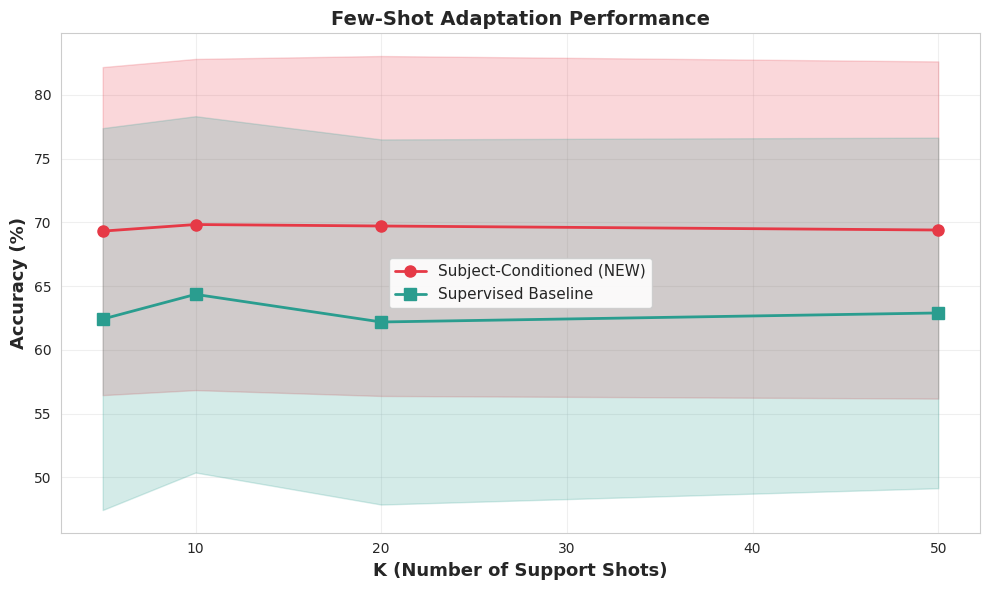


▶ Saving experimental configuration...

▶ Saving complete results pickle...
  ✓ Saved to: /kaggle/working/results_subject_conditioned/complete_results_seed456.pkl

 ✓ SEED 456 COMPLETE!

Results: /kaggle/working/results_subject_conditioned
Figures: /kaggle/working/results_subject_conditioned/figures
Metrics: /kaggle/working/results_subject_conditioned/metrics

📊 KEY FINDINGS TO CHECK:
   1. Subject-Conditioned should show LOWER variance than Supervised
   2. Better performance at low K (5, 10) due to explicit subject modeling
   3. Monotonic improvement with K (no degradation)
   4. Subject embedding z_s effectively captures subject-specific geometry

⚠️ TO RUN NEXT SEED:
   1. Change SEED = 456 to SEED = 123 (or 456)
   2. Restart kernel and run all cells
   3. Repeat for all 3 seeds: 42, 123, 456


In [10]:
# ═══════════════════════════════════════════════════════════════════
# PUBLICATION-QUALITY EXPERIMENTAL PIPELINE
# ═══════════════════════════════════════════════════════════════════
# 
# ⚠️ IMPORTANT FOR KAGGLE:
# Run ONE seed at a time to avoid session timeout!
# Change SEED below and rerun for each: 42, 123, 456
# ═══════════════════════════════════════════════════════════════════

print(f"\n{'='*70}")
print(" SUBJECT-CONDITIONED META-LEARNING - PUBLICATION RUN")
print(f"{'='*70}")

# ─── CONFIGURATION FOR PUBLICATION ───
SEED = 456  # ⚠️ CHANGE THIS: 42, 123, or 456 (run one at a time!)

FINAL_CONFIG = {
    'k_shots': [5, 10, 20, 50],
    'n_meta_iterations': 500,      # 1000 if time allows
    'meta_batch_size': 4,
    'n_support': 10,
    'n_query': 40,
    'subject_embed_dim': 32,       # NEW: Dimension of z_s (increased for more capacity)
    'encoder_hidden': 64,
    'encoder_output': 32,
    'inner_lr': 0.01,
    'outer_lr': 0.0003,            # Lower LR for stability
    'inner_steps': 5,
    'adapt_encoder': False,        # Adapt task head only (default)
    'device': Config.DEVICE
}

K_SHOTS = FINAL_CONFIG['k_shots']
N_META_ITERATIONS = FINAL_CONFIG['n_meta_iterations']
DEVICE = FINAL_CONFIG['device']

print(f"\n{'='*70}")
print(f" SEED: {SEED} (ONE SEED PER RUN)")
print(f"{'='*70}")
print(f"\nDevice: {DEVICE}")
print(f"K-shots: {K_SHOTS}")
print(f"Meta-iterations: {N_META_ITERATIONS}")
print(f"Subject embed dim: {FINAL_CONFIG['subject_embed_dim']}")
print(f"Inner LR: {FINAL_CONFIG['inner_lr']}")
print(f"Outer LR: {FINAL_CONFIG['outer_lr']}")
print(f"Inner steps: {FINAL_CONFIG['inner_steps']}")
print(f"Adapt encoder: {FINAL_CONFIG['adapt_encoder']}")
print(f"Subjects: {len(loso_splits)}")
print(f"\n⏱️ Estimated time: ~2-3 hours for full pipeline")
print(f"{'='*70}\n")

# ─── STEP 1: Subject-Conditioned Meta-Learning (NEW) ───
print(f"\n{'='*70}")
print(f" STEP 1/3: SUBJECT-CONDITIONED META-LEARNING (Seed: {SEED}) [NEW]")
print(f"{'='*70}")
print("\n⚠️  This is the NEW method that addresses the bottleneck:")
print("   - Infers subject embedding z_s from support set")
print("   - Conditions encoder with FiLM layers")
print("   - Meta-learns SubjectEncoder + ConditionedEEGEncoder")
print("   - Adapts TaskHead per subject")
print("")

subject_conditioned_results = train_subject_conditioned_loso(
    loso_splits=loso_splits,
    k_shots=K_SHOTS,
    n_meta_iterations=N_META_ITERATIONS,
    meta_batch_size=FINAL_CONFIG['meta_batch_size'],
    n_support=FINAL_CONFIG['n_support'],
    n_query=FINAL_CONFIG['n_query'],
    subject_embed_dim=FINAL_CONFIG['subject_embed_dim'],
    encoder_hidden=FINAL_CONFIG['encoder_hidden'],
    encoder_output=FINAL_CONFIG['encoder_output'],
    inner_lr=FINAL_CONFIG['inner_lr'],
    outer_lr=FINAL_CONFIG['outer_lr'],
    inner_steps=FINAL_CONFIG['inner_steps'],
    adapt_encoder=FINAL_CONFIG['adapt_encoder'],
    device=DEVICE,
    seed=SEED
)

print(f"\n{'='*70}")
print(f"✓ Subject-conditioned meta-learning complete for seed {SEED}!")
print(f"{'='*70}")

# ─── STEP 2: Supervised Baseline (for comparison) ───
print(f"\n{'='*70}")
print(f" STEP 2/3: SUPERVISED BASELINE (Seed: {SEED})")
print(f"{'='*70}")

supervised_results = run_supervised_baseline_loso(
    loso_splits=loso_splits,
    k_shots=K_SHOTS,
    hidden_dim=64,
    lr=0.01,
    n_epochs=100,
    device=DEVICE,
    seed=SEED
)

print(f"\n✓ Supervised baseline complete for seed {SEED}!")

# ─── STEP 3: Results & Visualization ───
print(f"\n{'='*70}")
print(f" STEP 3/3: RESULTS & VISUALIZATION (Seed: {SEED})")
print(f"{'='*70}")

# Compile results
all_results = {
    'Subject-Conditioned (NEW)': subject_conditioned_results,
    'Supervised Baseline': supervised_results
}

method_names = ['Subject-Conditioned (NEW)', 'Supervised Baseline']

# Print summary table
print("\n▶ Computing summary statistics...")
summary_df = print_final_summary_table(all_results, method_names, K_SHOTS)

# Save results to CSV
print("\n▶ Saving results to CSV...")
save_results_to_csv(all_results, method_names, Config.METRICS_DIR)

# Plot adaptation curves
print("\n▶ Generating adaptation curves...")
plot_adaptation_curves(
    all_results,
    method_names,
    save_path=os.path.join(Config.FIGURES_DIR, f'adaptation_curves_seed{SEED}.png')
)

# Save configuration
print("\n▶ Saving experimental configuration...")
config_dict = {
    'method': 'Subject-Conditioned Meta-Learning',
    'dataset_root': Config.DATASET_ROOT,
    'k_shots': K_SHOTS,
    'random_seed': SEED,
    'n_meta_iterations': N_META_ITERATIONS,
    'subject_embed_dim': FINAL_CONFIG['subject_embed_dim'],
    'encoder_hidden': FINAL_CONFIG['encoder_hidden'],
    'encoder_output': FINAL_CONFIG['encoder_output'],
    'inner_lr': FINAL_CONFIG['inner_lr'],
    'outer_lr': FINAL_CONFIG['outer_lr'],
    'inner_steps': FINAL_CONFIG['inner_steps'],
    'adapt_encoder': FINAL_CONFIG['adapt_encoder'],
    'meta_batch_size': FINAL_CONFIG['meta_batch_size'],
    'n_support': FINAL_CONFIG['n_support'],
    'n_query': FINAL_CONFIG['n_query'],
    'device': str(DEVICE),
    'innovation': 'FiLM conditioning with learned subject embedding z_s'
}

with open(os.path.join(Config.RESULTS_DIR, f'experimental_config_seed{SEED}.json'), 'w') as f:
    json.dump(config_dict, f, indent=2)

# Save complete results
print("\n▶ Saving complete results pickle...")
import pickle
results_path = os.path.join(Config.RESULTS_DIR, f'complete_results_seed{SEED}.pkl')
with open(results_path, 'wb') as f:
    pickle.dump({
        'subject_conditioned_results': subject_conditioned_results,
        'supervised_results': supervised_results,
        'all_results': all_results,
        'config': config_dict,
        'summary_df': summary_df
    }, f)
print(f"  ✓ Saved to: {results_path}")

print(f"\n{'='*70}")
print(f" ✓ SEED {SEED} COMPLETE!")
print(f"{'='*70}")
print(f"\nResults: {Config.RESULTS_DIR}")
print(f"Figures: {Config.FIGURES_DIR}")
print(f"Metrics: {Config.METRICS_DIR}")
print(f"\n📊 KEY FINDINGS TO CHECK:")
print(f"   1. Subject-Conditioned should show LOWER variance than Supervised")
print(f"   2. Better performance at low K (5, 10) due to explicit subject modeling")
print(f"   3. Monotonic improvement with K (no degradation)")
print(f"   4. Subject embedding z_s effectively captures subject-specific geometry")
print(f"\n⚠️ TO RUN NEXT SEED:")
print(f"   1. Change SEED = {SEED} to SEED = 123 (or 456)")
print(f"   2. Restart kernel and run all cells")
print(f"   3. Repeat for all 3 seeds: 42, 123, 456")
print(f"{'='*70}")